In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm
import os,sys, math
import matplotlib.pyplot as plt

本文是[论文](https://www.mdpi.com/2076-3417/10/20/7302)的一个学习总结， 该论文主要讲述了针对滚动轴承的包络分析法。

# 基于包络分析的滚动轴承故障频率判断

首先请看下图了解几个轴承参数
![轴承参数](./images/bearing_parameters.jpg)


## 滚动轴承故障探测

当滚动轴承的滚珠撞击内圈、外圈上的蚀点、裂纹等故障体后， 就会以如下集中频率产生撞击信号

$BPFO (Ball Pass Frequency Outer race) = \dfrac{nf_s}{2}\left\{1+\dfrac{d}{D}cos\alpha\right\}$

$BPFI (Ball Pass Frequence Inner race) = \dfrac{nf_s}{2}\left\{1-\dfrac{d}{D}cos\alpha\right\}$ 

$FTF (Fundamental Train Frequence) = \dfrac{f_s}{2}\left\{1-\dfrac{d}{D}cos\alpha\right\}$

$BSF (Ball Spin Frequency) = \dfrac{Df_s}{d}\left\{ 1-\left( \dfrac{d}{D}cos\alpha \right)^2 \right\} $

上述公式中 $D, d, \alpha, n 和f_s$分别指代 轴承的外圈直径， 滚珠的直径， 滚珠和保持架的接触角， 滚珠数量， 轴承转速
当轴承中产生了撞击的故障信号后， 会同时不断产生高频共振信号， 再加上其它轴承的固有信号， 相当于高频共振信号与低频故障信号和其它信号做了一个调制。故障信号极有可能被淹没在其它大幅值的信号之中导致无法被检出。

### 故障信号调制

其实应该说是故障信号被淹没在其它信号之中， 因为撞击产生的故障信号和共振信号， 轴承本身的信号， 白噪声等一起被调制产生出无法直接观察到故障频率的信号。 我们来看一下调制过程。

![故障信号](./images/故障信号.jpg)

上图是故障信号本身， 它将会被后面的高频信号调制

![载波信号](./images/载波信号.jpg)

上图就是高频共振信号，它将会成为故障信号的载波信号用于调制故障信号。

![信号调制](./images/信号调制.jpg)

故障信号被高频信号调制以后,

![信号包络](./images/信号包络.jpg)

通过包络检波方法提取故障信号包络，从而获得故障频率信号。如上图这个比较纯净的调制信号，通过包络分析(当前我还是没能明白为何hilbert transform以后的数据就成为了包络数据)就可以得到低频的也就是故障信号数据，这个时候再通过频谱分析的时候就可以找到故障频率。拿到这个故障频率再查看一下它的幅值，同时和轴承的各个不同的故障频率作比较就可以知道具体故障类型了。


我们先构造一个最简单的故障信号， 并使用包络分析法来检故障信号，用以说明该包络分析法的具体使用方式。当遇到真实故障数据以后我们需要掌握更多的技巧以避免在信号分析的时候陷入噪声信号之中。

首先，我们假设有一个轴承，它的基本参数如下：
1. 外圈直径 40mm
2. 内圈直径 30mm
3. 滚珠中心距离轴承中心距离 35mm
4. 故障数量8个
5. 滚珠直径 8mm
6. 滚珠和轴承内外圈的接触角为 0 度
7. 轴承转数 50Hz
8. 采样频率25.6kHz
9. 采样时长0.64s
如此可得，该轴承的基本故障频率如下

In [2]:
outer_race_diameter = 40 / 1000.0
inner_race_diameter = 30 / 1000.0
bearing_mean_diameter = 35 / 1000.0
ball_count = 8
ball_diameter = 8 / 1000.0
contact_angle = 0 * np.pi
fs = 20

# 下面的数据之所以要取整是为了后面计算fault signal的时候方便
bpfo = np.rint(fs * ball_count / 2.0 * (1 + ball_diameter / bearing_mean_diameter * np.cos(contact_angle))).astype(np.int32)
bpfi = np.rint(fs * ball_count / 2.0 * (1 - ball_diameter / bearing_mean_diameter * np.cos(contact_angle))).astype(np.int32)
ftf  = np.rint(fs / 2.0 * (1 - ball_diameter / bearing_mean_diameter *np.cos(contact_angle))).astype(np.int32)
bsf  = np.rint(fs * bearing_mean_diameter / ball_diameter * (1 - (ball_diameter / bearing_mean_diameter * np.cos(contact_angle))**2)).astype(np.int32)
print(f"bpfi={bpfi} bpfo={bpfo} ftf={ftf} bsf={bsf}")

bpfi=62 bpfo=98 ftf=8 bsf=83


计算出基本的故障频率以后，我们开始模拟故障数据。
模拟数据主要由如下几个信号数据组成
1. 故障信号数据
2. 高频响应数据
3. 白噪声数据
4. 轴承离散数据

其中故障信号数据，会不断的衰减，每一次该数据产生以后就会以一定的衰减速度进行衰减，直到再次产生该数据。产生这个故障新的频率应该和故障频率一直。 该衰减信号最终会被高频响应数据调制，形成调幅数据。同时我们添加一些白噪声和轴承固有的一些数据

In [3]:
# sample rate 弄小一点，不然算得太累了。
sample_rate = 3e3
sample_duration = 6000 / sample_rate
sample_count = int(sample_rate * sample_duration)
sample_interval = 1.0 /sample_rate

fault_frequency = 10
carrier_frequency = 600

fault_signal_amplitude = 10

carrier_signal_amplitude = 1

damping_rate = 0.5

white_noise_mu = 0.5
white_noise_sigma = 1.2
white_noise_amplitude = 1

background_noise_amplitude = 2.0
background_noise_frequency = fault_frequency + 20 # 需要担心这个频率是否会和其它的故障频率相近

sample_index = np.arange(0, sample_count)
time_series = np.arange(0, sample_duration, sample_interval)

def show_time_domain(x, y, title):
    plt.plot(x, y, color="green")
    plt.xlabel("time")
    plt.ylabel("amplitude")
    plt.title(title)

def show_freq_domain(x, y, title):
    freq = np.fft.rfftfreq(len(x), sample_interval)
    amplitude = np.abs(np.fft.rfft(y))
    plt.plot(freq, amplitude, color="blue")
    plt.xlabel("frequency")
    plt.ylabel("amplitude")
    plt.title(title)

print(f"fault_signal {fault_frequency}, carrier_signal {carrier_frequency}")

fault_signal 10, carrier_signal 600


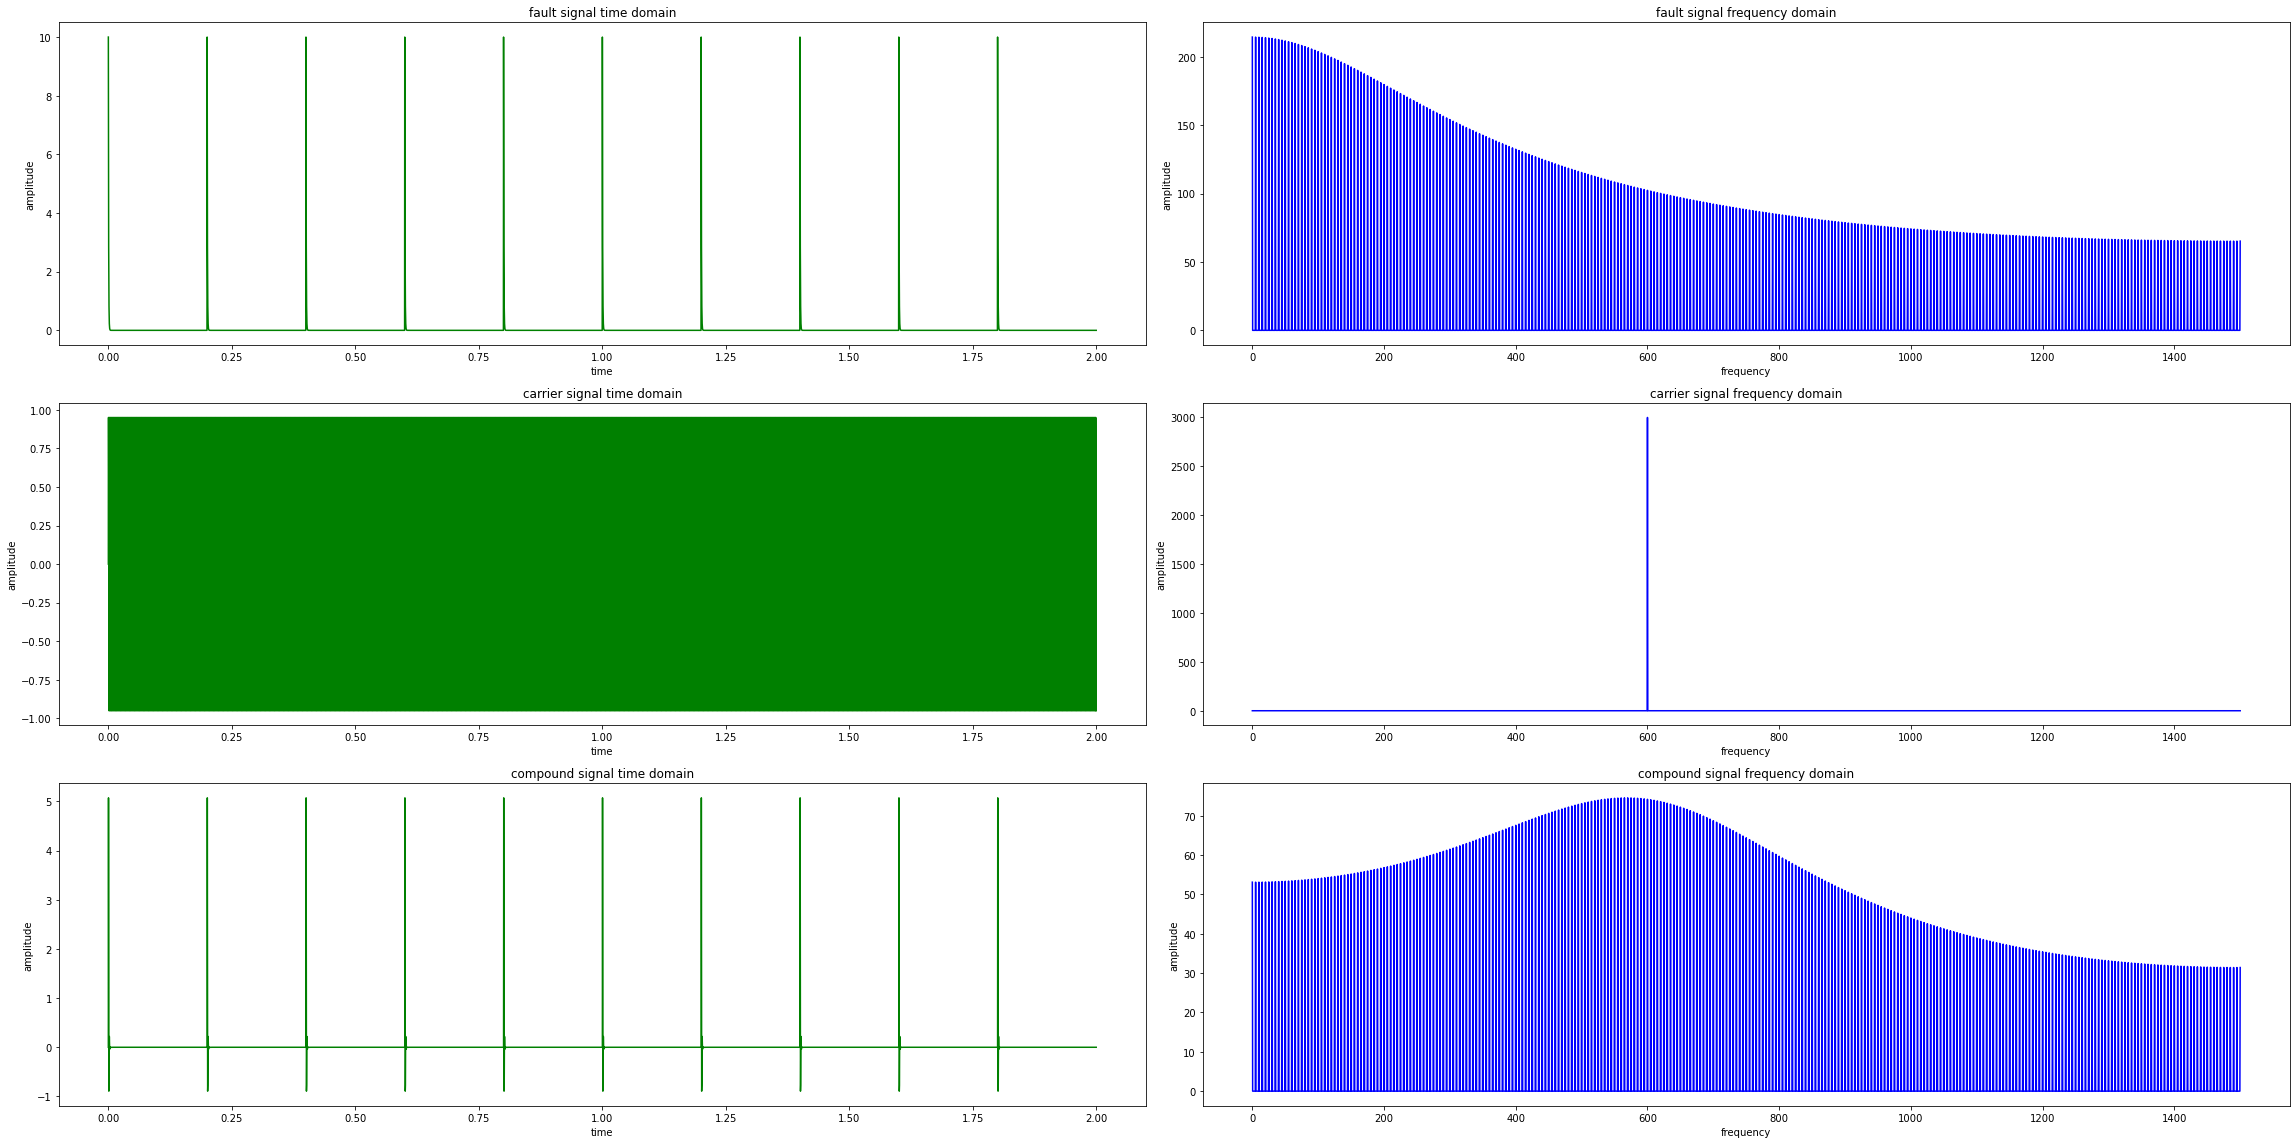

In [4]:
# 生成故障信号数据以及高频响应数据
fault_signal = fault_signal_amplitude * np.exp(- damping_rate * 2 * np.pi * carrier_frequency * (sample_index % carrier_frequency) * sample_interval)
carrier_signal = carrier_signal_amplitude * np.sin( 2 * np.pi * carrier_frequency * (sample_index % carrier_frequency) * sample_interval)
# carrier_signal = carrier_signal_amplitude * np.sin( 2 * np.pi * carrier_frequency * time_series)
compound_signal = fault_signal * carrier_signal

# show fault signal, carrier signal and compound signal by modulating them

plt.figure(figsize=(32, 16))

plt.subplot(3, 2, 1)
show_time_domain(time_series, fault_signal, "fault signal time domain")
plt.subplot(3, 2, 2)
show_freq_domain(time_series, fault_signal, "fault signal frequency domain")


plt.subplot(3, 2, 3)
show_time_domain(time_series, carrier_signal, "carrier signal time domain")
plt.subplot(3, 2, 4)
show_freq_domain(time_series, carrier_signal, "carrier signal frequency domain")

plt.subplot(3, 2, 5)
show_time_domain(time_series, compound_signal, "compound signal time domain")
plt.subplot(3, 2, 6)
show_freq_domain(time_series, compound_signal, "compound signal frequency domain")
    
plt.tight_layout()
plt.show()

当然了，上面这个数据实在是简单了点，我们再加上其它假设的噪声和白噪声。

sample_count 6000 


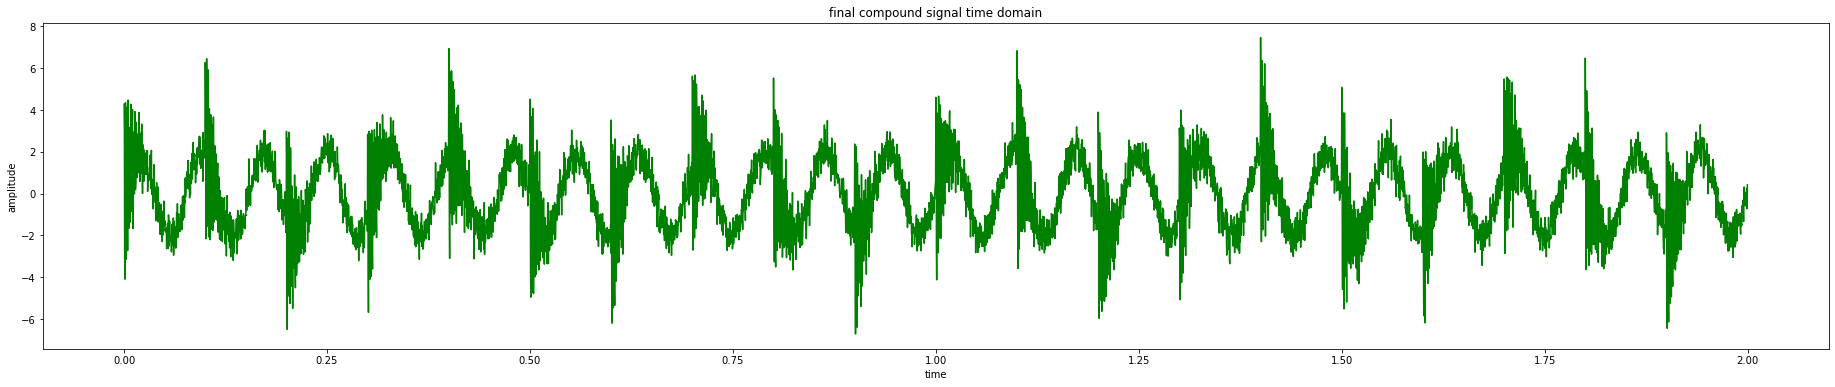

In [14]:
# white_noise = white_noise_amplitude * np.random.normal(white_noise_mu, white_noise_sigma, len(time_series))

# background_noise = background_noise_amplitude * np.sin( 2 * np.pi * time_series * background_noise_frequency)

# signal = compound_signal + white_noise + background_noise

# plt.figure(figsize=(32,16))

# plt.subplot(3, 2, 1)
# show_time_domain(time_series, white_noise, "white noise time domain")
# plt.subplot(3, 2, 2)
# show_freq_domain(time_series, white_noise, "white noise frequency domain")

# plt.subplot(3, 2, 3)
# show_time_domain(time_series, background_noise, "background noise time domain")
# plt.subplot(3, 2, 4)
# show_freq_domain(time_series, background_noise, "background noise frequency domain")

# plt.subplot(3, 2, 5)
# show_time_domain(time_series, signal, "final compound signal time domain")
# plt.subplot(3, 2, 6)
# show_freq_domain(time_series, signal, "final compound signal frequency domain")

# plt.tight_layout()
# plt.show()
import scipy.io as sio

signal = sio.loadmat("simulation")
signal = signal["vib"][:]
signal = signal.reshape((6000,))

print(f"sample_count {sample_count} ")
plt.figure(figsize=(32,6))
show_time_domain(time_series, signal, "final compound signal time domain")

现在我们来学着如何从上面这个模拟信号里面分离出故障信号。当然了，其实从上面这个频谱图就可以很容易看出来故障频率是啥。我们现在假设我们看不出来哈。^_^  

我们首先利用AR(自动回归)来处理一下生成的signal，目的是为了去掉backgground noise和white noise. 这个原理也很简单， AR(自动回归)是一种平稳信号预测算法， 也就是说它处理的目标是平稳信号，聪明的你也需要开始犯嘀咕了。实际情况中的信号肯定不是平稳信号，为何要用AR来处理呢。其实是这样的， 我们首先利用AR基于已有的信号进行处理，然后根据AR预测出一个平稳信号。然后用原始信号减去这个预测的平稳信号，那么我们就会得到一个残差信号， 这个残差信号就包含了很多故障信号的数据。 

AR有一个order的问题，也就是说用多少阶来作为基本参数，并且获取AR parameter呢？
这里采用一个比较直观的方法， 那就是基于峭度判断的AR order selection算法。


C:\Users\DELL\anaconda3\envs\dl\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


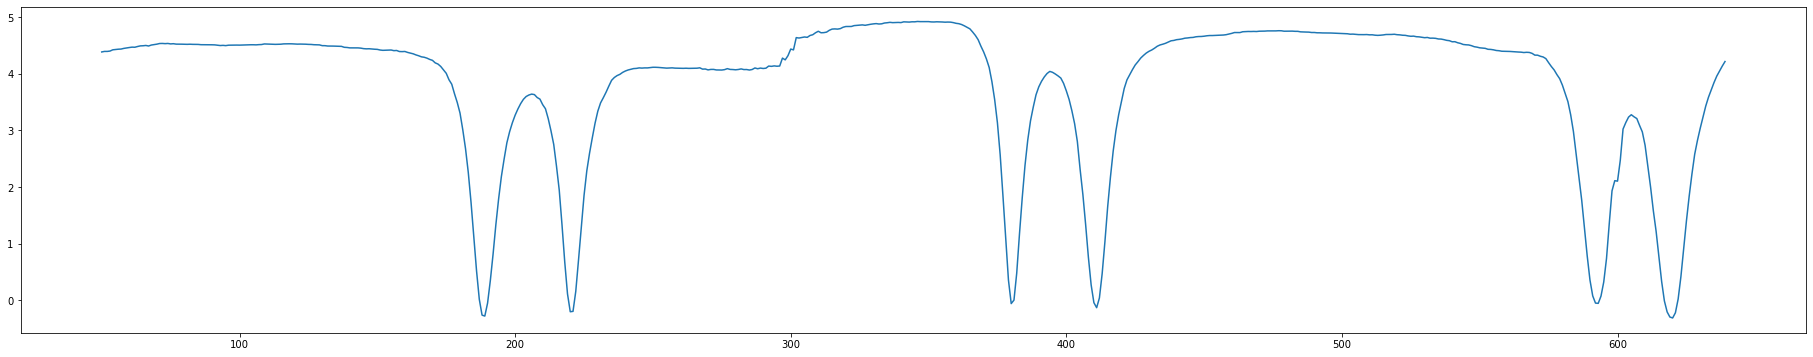

best order is: 346


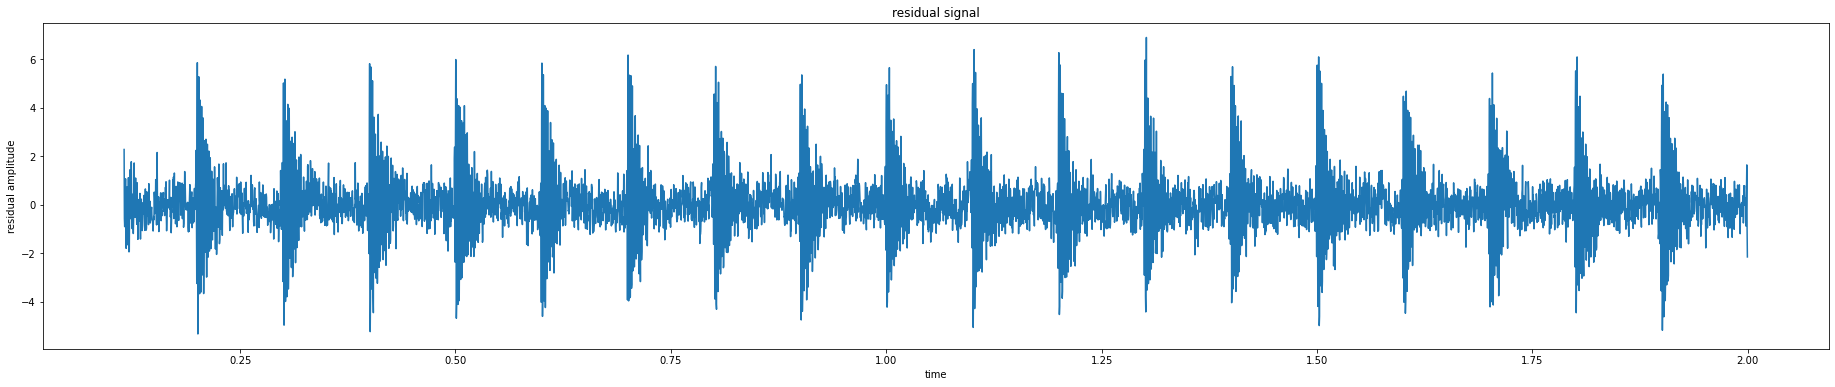

In [10]:
# 首先，我们需要选取一个合适AR order， order越大计算量越大，但是预测的准确度也越高。
# 那么AR order究竟选多少呢， 这里纯靠硬算，也就是选一个max order, 然后从2开始一直到max order
# 每一个order预测后形成一个残差， 然后计算这个残差得峭度， 我们认为峭度最大得时候得那么order就是我们得AR order

def calc_kurtosis_by_order(order, x, y):
    # step 1, 使用yule-walker算法，计算出ar parameter
    ar_parameters, _ = sm.regression.yule_walker(y, order=order)
    m = np.zeros((len(y), order))
    for p in range(1, order):
        m[p:, p] = y[ : len(y) -p]
    y2 = np.matmul(m, np.transpose(ar_parameters))
    # step 2, 针对使用AR预测得序列， 求得残差其峭度值
    y_hat = y - y2
    kurtosis = sp.stats.kurtosis(y_hat[order+1:])
    return order, kurtosis, y_hat

max_order = int(sample_count / fault_frequency + 40) # 这是一个取巧得方法， 真实得做法是用采样数除以最小得故障频率

kutorsis_array = []
orders = []
best_order = 0
best_residual = None
max_kurtosis = -999
for p in range(50, max_order):
    _, kurtosis, residual = calc_kurtosis_by_order(p, time_series, signal)
    orders.append(p)
    kutorsis_array.append(kurtosis)
    if(max_kurtosis < kurtosis):
        max_kurtosis = kurtosis
        best_order = p
        best_residual = residual
plt.figure(figsize=(32,6))
plt.plot(orders, kutorsis_array)
plt.show()
print(f"best order is: {best_order}")

plt.figure(figsize=(32,6))
plt.plot(time_series[best_order:], best_residual[best_order:])
plt.title("residual signal")
plt.xlabel("time")
plt.ylabel("residual amplitude")
plt.show()

使用短时傅里叶对残差信号进行处理， 目的是为了找到高频响应频率范围

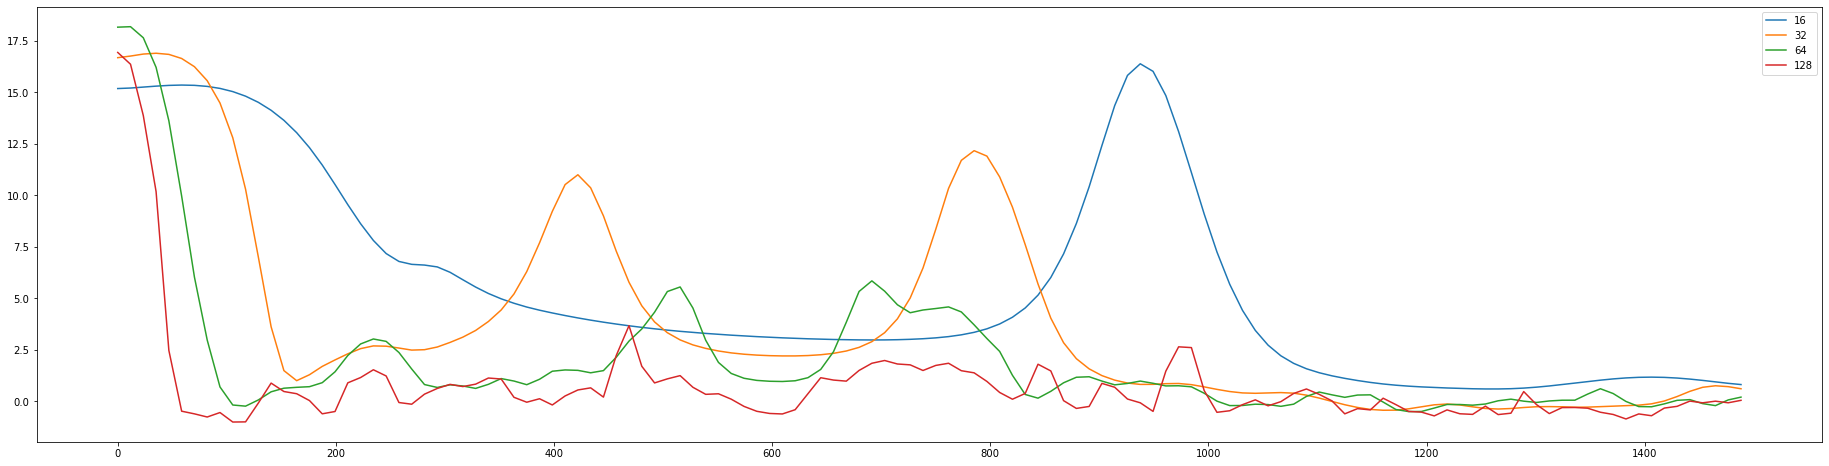

In [11]:
def stft(time_series, signal, window_length, max_freq_length):
    window_function = sp.signal.windows.hann(window_length)
    number_overlapped = math.ceil(window_length / 2)
    window_count =  math.floor((len(signal) - number_overlapped) / (window_length - number_overlapped))
    window_start, window_end = 0, window_length
    stft = np.zeros((window_count, max_freq_length))
    step = window_length - number_overlapped
    for window in range(window_count):
        fft = np.fft.fft(signal[window_start:window_end] * window_function, n=2 * max_freq_length)
        fft = np.abs(fft[:max_freq_length]) / max_freq_length / np.sqrt(np.mean(window_function**2))*2
        stft[window,:] = np.transpose(fft)
        window_start, window_end = window_start + step, window_end + step
    kurtosis_array = [0] * max_freq_length
    for idx in range(max_freq_length):
        kurtosis_array[idx] = sp.stats.kurtosis(stft[:, idx])
    return kurtosis_array

wind_length = [2**4, 2**5, 2**6, 2**7]
max_freq_length = wind_length[-1]
spectrum_kurtosis = np.zeros((len(wind_length), max_freq_length))
for idx, win in enumerate(wind_length):
    kurtosis = stft(time_series, best_residual, win, max_freq_length)
    spectrum_kurtosis[idx, :] = kurtosis
freq = np.arange(0, max_freq_length) / (2 * max_freq_length) * sample_rate
plt.figure(figsize=(32,8))
plt.plot(freq, np.transpose(spectrum_kurtosis))
plt.legend(wind_length)
plt.show()